### Monitoring of the water extent of Lake Neusiedl and the Lacken:

#### Libraries

In [2]:
import os
import glob
from osgeo import gdal
import pprint
import numpy as np
from yeoda.datacube import DataCubeReader
from geopathfinder.naming_conventions.yeoda_naming import YeodaFilename
import pandas as pd

#### Reading Data

In [3]:
tile_1 = r"/Users/nadia/Desktop/TUSS24/intproject/e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N015T1"
tile_1 = glob.glob(os.path.join(tile_1, "*"))

In [4]:
tile_2 = r"/Users/nadia/Desktop/TUSS24/intproject/e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N015T1"
tile_2 = glob.glob(os.path.join(tile_2, "*"))

In [16]:
mask = r"/Users/nadia/Desktop/TUSS24/intproject/e11739391/reference/EQUI7_EU010M/E052N015T1"
mask = glob.glob(os.path.join(mask, "*"))

In [17]:
dimensions = ["time", "tile_name", "var_name", "sensor_field", "data_version"]
mask1_reader = DataCubeReader.from_filepaths(mask, fn_class=YeodaFilename, dimensions=dimensions,
                                          stack_dimension="time", tile_dimension="tile_name")
mask1_reader.file_register.head(20)

,filepath,var_name,sensor_field,tile_name,data_version,time
0,/Users/nadia/Desktop/TUSS24/intproject/e117393...,MASK,None,E052N015T1,None,2022-05-17
1,/Users/nadia/Desktop/TUSS24/intproject/e117393...,MASK,None,E052N015T1,None,2022-10-20
2,/Users/nadia/Desktop/TUSS24/intproject/e117393...,MASK,None,E052N015T1,None,2022-12-07
3,/Users/nadia/Desktop/TUSS24/intproject/e117393...,MASK,None,E052N015T1,None,2022-11-01
4,/Users/nadia/Desktop/TUSS24/intproject/e117393...,MASK,None,E052N015T1,None,2022-06-10
5,/Users/nadia/Desktop/TUSS24/intproject/e117393...,MASK,None,E052N015T1,None,2022-03-06
6,/Users/nadia/Desktop/TUSS24/intproject/e117393...,MASK,None,E052N015T1,None,2022-02-10
7,/Users/nadia/Desktop/TUSS24/intproject/e117393...,MASK,None,E052N015T1,None,2022-07-24
8,/Users/nadia/Desktop/TUSS24/intproject/e117393...,MASK,None,E052N015T1,None,2022-09-22
9,/Users/nadia/Desktop/TUSS24/intproject/e117393...,MASK,None,E052N015T1,None,2022-04-11


In [5]:
dimensions = ["time", "tile_name", "var_name", "sensor_field", "data_version"]
tile1_reader = DataCubeReader.from_filepaths(tile_1, fn_class=YeodaFilename, dimensions=dimensions,
                                          stack_dimension="time", tile_dimension="tile_name")
tile1_reader.file_register.head(20)

,filepath,var_name,sensor_field,tile_name,data_version,time
0,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E053N015T1,V1M0R01,2022-09-22 16:42:50
1,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E053N015T1,V1M0R01,2022-01-17 05:02:29
2,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E053N015T1,V1M0R01,2022-06-10 05:02:33
3,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E053N015T1,V1M0R01,2022-04-11 05:02:29
4,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E053N015T1,V1M0R01,2022-12-07 05:02:12
5,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E053N015T1,V1M0R01,2022-10-20 05:02:38
6,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E053N015T1,V1M0R01,2022-07-24 16:42:48
7,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E053N015T1,V1M0R01,2022-03-06 05:02:28
8,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E053N015T1,V1M0R01,2022-09-22 16:43:15
9,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E053N015T1,V1M0R01,2022-02-10 05:02:29


In [6]:
# tile1_reader.file_register.sort_values("time")

In [8]:
tile1_reader.file_register.count()

filepath        48
data_version    48
sensor_field    48
var_name        48
tile_name       48
time            48
dtype: int64

In [12]:
tile1_reader.select_by_dimension(lambda s: s == "2022-01-17 05:02:29",name="time").file_register



,filepath,data_version,sensor_field,var_name,tile_name,time
1,/Users/nadia/Desktop/TUSS24/intproject/e117393...,V1M0R01,S1AIWGRDH,GMR40,E053N015T1,2022-01-17 05:02:29
35,/Users/nadia/Desktop/TUSS24/intproject/e117393...,V1M0R01,S1AIWGRDH,GMR40,E053N015T1,2022-01-17 05:02:29


In [13]:
# 12 time stamps - files splitt in 2 -> 24 unique time values
tile1_reader.file_register['time'].unique()


<DatetimeArray>
['2022-09-22 16:42:50', '2022-01-17 05:02:29', '2022-06-10 05:02:33',
 '2022-04-11 05:02:29', '2022-12-07 05:02:12', '2022-10-20 05:02:38',
 '2022-07-24 16:42:48', '2022-03-06 05:02:28', '2022-09-22 16:43:15',
 '2022-02-10 05:02:29', '2022-11-01 05:02:13', '2022-07-24 16:43:13',
 '2022-08-05 16:42:49', '2022-08-05 16:43:14', '2022-05-17 05:02:05',
 '2022-06-10 05:02:08', '2022-12-07 05:02:37', '2022-10-20 05:02:13',
 '2022-02-10 05:02:04', '2022-03-06 05:02:03', '2022-05-17 05:02:30',
 '2022-11-01 05:02:38', '2022-04-11 05:02:04', '2022-01-17 05:02:04']
Length: 24, dtype: datetime64[ns]

In [7]:
tile2_reader = DataCubeReader.from_filepaths(tile_2, fn_class=YeodaFilename, dimensions=dimensions,
                                          stack_dimension="time", tile_dimension="tile_name")
tile2_reader.file_register.head(20)

,filepath,var_name,sensor_field,tile_name,data_version,time
0,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E052N015T1,V1M0R01,2022-06-10 05:02:08
1,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E052N015T1,V1M0R01,2022-12-07 05:02:37
2,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E052N015T1,V1M0R01,2022-10-20 05:02:13
3,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E052N015T1,V1M0R01,2022-02-10 05:02:04
4,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E052N015T1,V1M0R01,2022-03-06 05:02:03
5,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E052N015T1,V1M0R01,2022-05-17 05:02:30
6,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E052N015T1,V1M0R01,2022-11-01 05:02:38
7,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E052N015T1,V1M0R01,2022-04-11 05:02:04
8,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E052N015T1,V1M0R01,2022-01-17 05:02:04
9,/Users/nadia/Desktop/TUSS24/intproject/e117393...,GMR40,S1AIWGRDH,E052N015T1,V1M0R01,2022-09-22 16:42:50


In [15]:
tile2_reader.file_register['time'].unique()

<DatetimeArray>
['2022-06-10 05:02:08', '2022-12-07 05:02:37', '2022-10-20 05:02:13',
 '2022-02-10 05:02:04', '2022-03-06 05:02:03', '2022-05-17 05:02:30',
 '2022-11-01 05:02:38', '2022-04-11 05:02:04', '2022-01-17 05:02:04',
 '2022-09-22 16:42:50', '2022-01-17 05:02:29', '2022-06-10 05:02:33',
 '2022-04-11 05:02:29', '2022-12-07 05:02:12', '2022-10-20 05:02:38',
 '2022-07-24 16:42:48', '2022-03-06 05:02:28', '2022-09-22 16:43:15',
 '2022-02-10 05:02:29', '2022-11-01 05:02:13', '2022-07-24 16:43:13',
 '2022-08-05 16:42:49', '2022-08-05 16:43:14', '2022-05-17 05:02:05']
Length: 24, dtype: datetime64[ns]

In [17]:
tile2_reader.file_register.count()

filepath        48
data_version    48
sensor_field    48
var_name        48
tile_name       48
time            48
dtype: int64

<GeoAxes: >

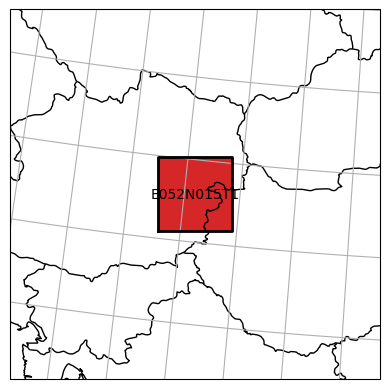

In [20]:
plot_extent = tile2_reader.mosaic.outer_extent
extent_bfr = 200e3
plot_extent = [plot_extent[0] - extent_bfr, plot_extent[1] - extent_bfr,
               plot_extent[2] + extent_bfr, plot_extent[3] + extent_bfr]
tile2_reader.mosaic.plot(label_tiles=True, extent=plot_extent)

<GeoAxes: >

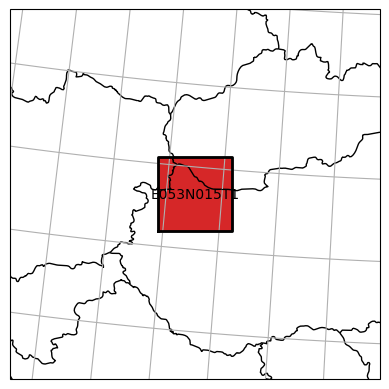

In [21]:
plot_extent = tile1_reader.mosaic.outer_extent
extent_bfr = 200e3
plot_extent = [plot_extent[0] - extent_bfr, plot_extent[1] - extent_bfr,
               plot_extent[2] + extent_bfr, plot_extent[3] + extent_bfr]
tile1_reader.mosaic.plot(label_tiles=True, extent=plot_extent)